# Benchmarking: retrieving and comparing against reference results

ou can access all the latest results for classification, clustering and
regression directly with aeon. These results are all stored on the website

[timeseriesclassification.com](https://timeseriesclassification.com). This notebook
is about recovering the latest results. Because of software changes, these may vary
slightly from published results. If you want to recover results published in one of
our bake offs, see the notebook  [Loading bake off results](./bakeoff_results.ipynb)

FreshPRINCE [4] is a pipeline of TSFresh transform followed by a rotation forest classifier.
InceptionTimeClassifier [5] is a deep learning ensemble. HIVECOTEV2 [6] is a meta
ensemble of four different ensembles built on different representations. WEASEL2 [7]
overhauls original WEASEL using dilation and ensembling randomized hyper-parameter
settings.

See [1] for an overview of recent advances in time series classification.

In [1]:
from aeon.benchmarking import plot_critical_difference
from aeon.benchmarking.results_loaders import (
    get_estimator_results,
    get_estimator_results_as_array,
)
from aeon.visualisation.results_plotting import plot_boxplot_median, plot_scatter

classifiers = [
    "FreshPRINCEClassifier",
    "HIVECOTEV2",
    "InceptionTimeClassifier",
    "WEASEL-Dilation",
]
datasets = ["ACSF1", "ArrowHead", "GunPoint", "ItalyPowerDemand"]
# get results. To read locally, set the path variable.
# If you do not set path, results are loaded from
# https://timeseriesclassification.com/results/ReferenceResults.
# You can download the files directly from there
default_split_all, data_names = get_estimator_results_as_array(estimators=classifiers)
print(
    " Returns an array with each column an estimator, shape (data_names, classifiers)"
)
print(
    f"By default recovers the default test split results for {len(data_names)} "
    f"equal length UCR datasets."
)
default_split_some, names = get_estimator_results_as_array(
    estimators=classifiers, datasets=datasets
)
print(
    f"Or specify datasets for result recovery. For example, {len(names)} datasets. "
    f"HIVECOTEV2 accuracy {names[3]} = {default_split_some[3][1]}"
)

 Returns an array with each column an estimator, shape (data_names, classifiers)
By default recovers the default test split results for 112 equal length UCR datasets.
Or specify datasets for result recovery. For example, 4 datasets. HIVECOTEV2 accuracy ItalyPowerDemand = 0.9698736637512148


If you have any questions about these results or the datasets, please raise an issue
on the associated [repo](https://github.com/time-series-machine-learning/tsml-repo). You can also recover
results in a dictionary, where each key is a classifier name, and the values is a
dictionary of problems/results.


In [2]:
hash_table = get_estimator_results(estimators=classifiers)
print("Keys = ", hash_table.keys())
print(
    "Accuracy of HIVECOTEV2 on ItalyPowerDemand = ",
    hash_table["HIVECOTEV2"]["ItalyPowerDemand"],
)

Keys =  dict_keys(['FreshPRINCEClassifier', 'HIVECOTEV2', 'InceptionTimeClassifier', 'WEASEL-Dilation'])
Accuracy of HIVECOTEV2 on ItalyPowerDemand =  0.9698736637512148


The results recovered so far have all been on the default train/test split. If we
merge train and test data and resample, you can get very different results. To allow
for this, we average results over 30 resamples. You can recover these
averages by setting the `default_only` parameter to `False`.

In [3]:
resamples_all, data_names = get_estimator_results_as_array(
    estimators=classifiers, default_only=False
)
print("Results are averaged over 30 stratified resamples.")
print(
    f" HIVECOTEV2 default train test partition of {data_names[3]} = "
    f"{default_split_all[3][1]} and averaged over 30 resamples = "
    f"{resamples_all[3][1]}"
)

Results are averaged over 30 stratified resamples.
 HIVECOTEV2 default train test partition of PhalangesOutlinesCorrect = 0.8344988344988346 and averaged over 30 resamples = 0.8437062937062937


So once you have the results you want, you can compare classifiers with built in aeon
 tools. For example, you can draw a critical difference diagram [7]. This displays
 the average rank of each estimator over all datasets. It then groups estimators for
 which there is no significant difference in rank into cliques, shown with a solid
 bar. So in the example below with the default train test splits,
 FreshPRINCEClassifier and WEASEL-Dilation are not significantly different in ranks to
 InceptionTimeClassifier, but HIVECOTEV2 is significantly better.
 The diagram below has been performed using pairwise Wilcoxon signed-rank tests and forms cliques using the Holm correction for multiple
testing as described in [8, 9]. Alpha value is 0.05 (default value).


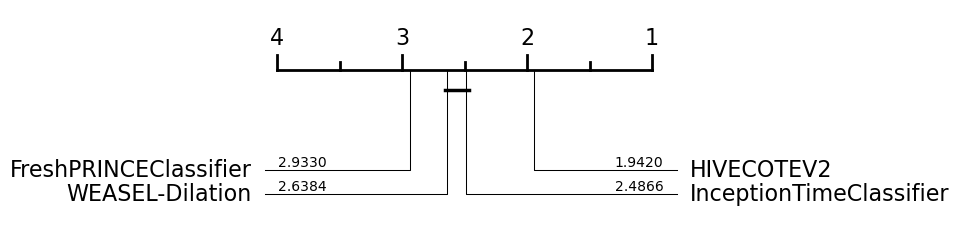

In [4]:
plot = plot_critical_difference(
    default_split_all, classifiers, test="wilcoxon", correction="holm"
)
plot.show()

If we use the data averaged over resamples, we can detect differences more clearly.
Now we see WEASEL-Dilation and InceptionTimeClassifier are significantly better than the
FreshPRINCEClassifier.

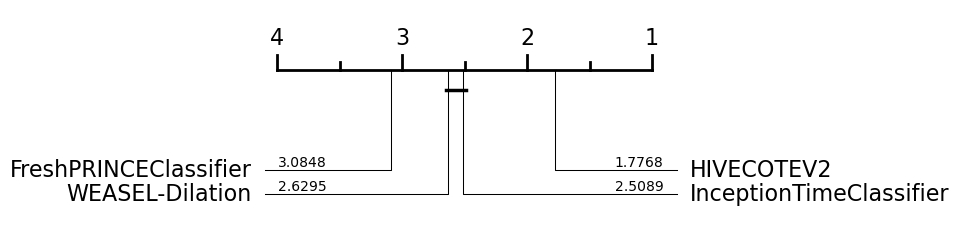

In [5]:
plot = plot_critical_difference(
    resamples_all, classifiers, test="wilcoxon", correction="holm"
)
plot.show()

If we want to highlight a specific classifier, we have the `highlight` parameter, which is a dict including the classifier that we would like to highlight and the colour selected, such as: `highlight={HIVECOTEV2: "#8a9bf8"}`

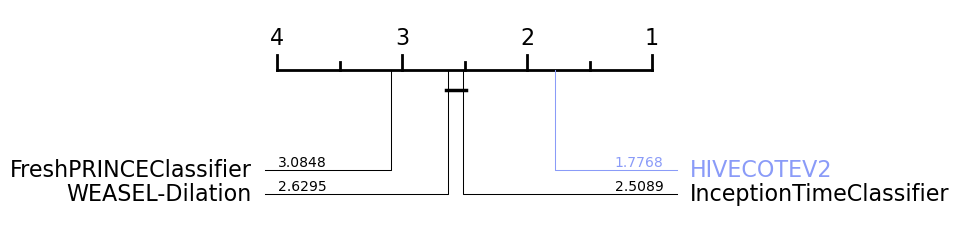

In [6]:
plot = plot_critical_difference(
    resamples_all,
    classifiers,
    test="wilcoxon",
    correction="holm",
    highlight={"HIVECOTEV2": "#8a9bf8"},
)
plot.show()

Besides plotting differences using the critical difference diagrams, different versions of boxplots can be plotted. Boxplots graphically demonstrates the locality, spread and skewness of the results. In this case, it plot a boxplot of distributions from the median. A value above 0.5 means the algorithm is better than the median accuracy for that particular problem.

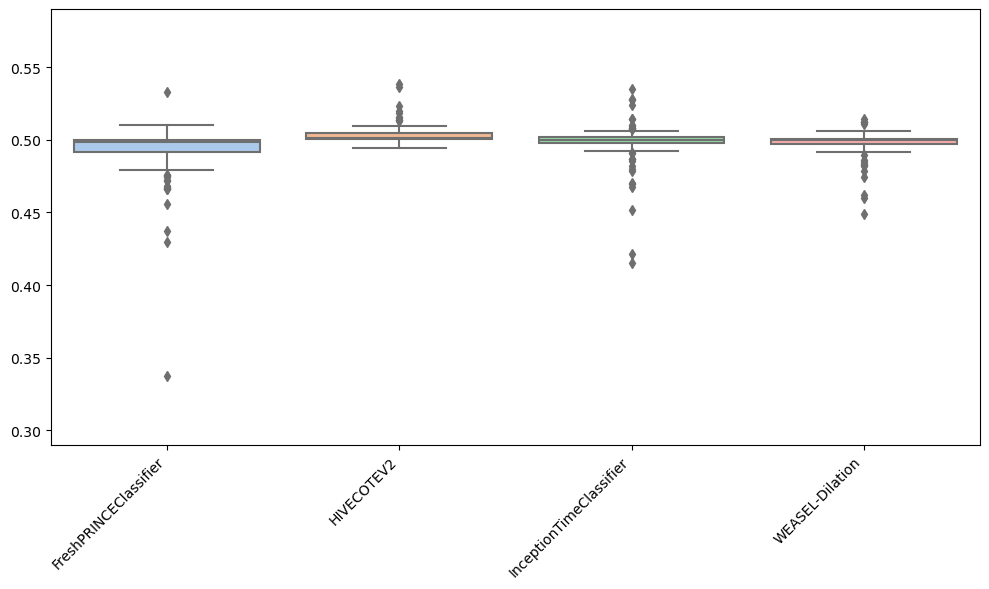

In [7]:
plot = plot_boxplot_median(
    resamples_all,
    classifiers,
    plot_type="boxplot",
    outliers=True,
)

plot.show()

As can be observed, the results achieved by the FreshPRINCEClassifier are more spreaded than the rest. Furthermore, it can be seen that most results for HC2 are above 0.5, which indicates that for most datasets, HC2 is better.

There are some more options to play with in this function. For example, to specify the values for the y-axis:

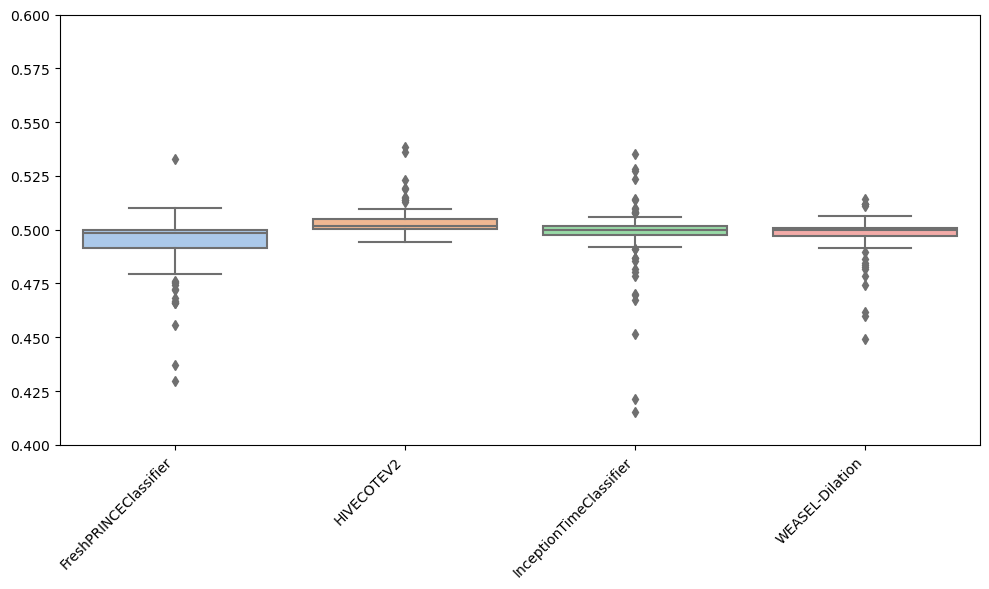

In [8]:
plot = plot_boxplot_median(
    resamples_all,
    classifiers,
    plot_type="boxplot",
    outliers=True,
    y_min=0.4,
    y_max=0.6,
)

plot.show()

Apart from well-known boxplots, different versions can be plotted, depending on the purpose of the user:
- `violin` is a hybrid of a boxplot and a kernel density plot, showing peaks in the data.
- `swarm` is a scatterplot with points adjusted to be non-overlapping.
- `strip` is similar to `swarm` but uses jitter to reduce overplotting.

Below, we show an example of the `violin` one, including a title.

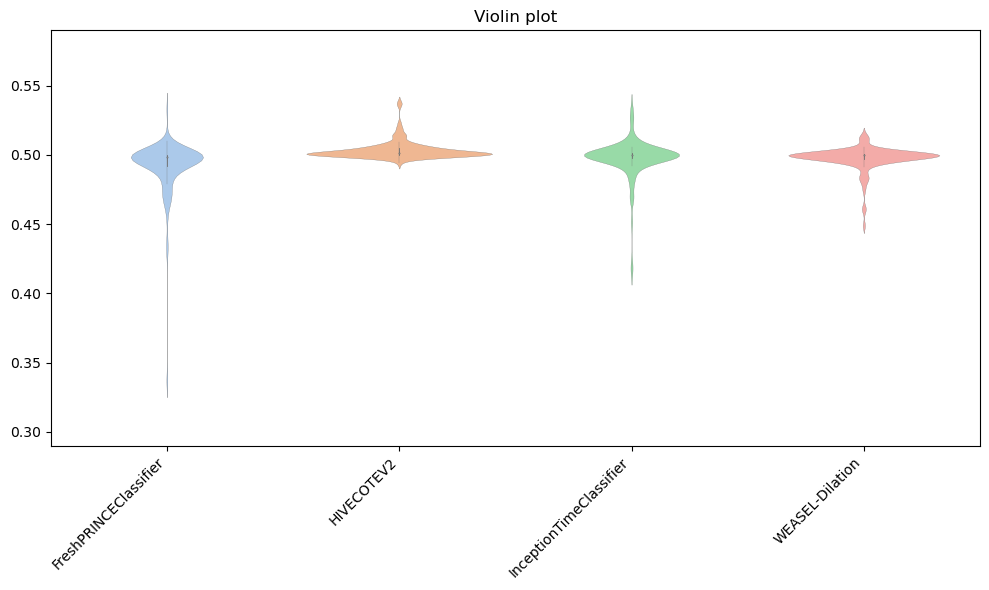

In [9]:
plot = plot_boxplot_median(
    resamples_all,
    classifiers,
    plot_type="violin",
    title="Violin plot",
)

plot.show()

From the critical difference diagram above, we showed that InceptionTimeClassifier is not significantly better than WEASEL-Dilation. Now, if we want to specifically compare the results of these two approaches, we can plot a scatter in which each point is a pair of accuracies of both approaches. The number of W, T, and L is also included per approach in the legend.

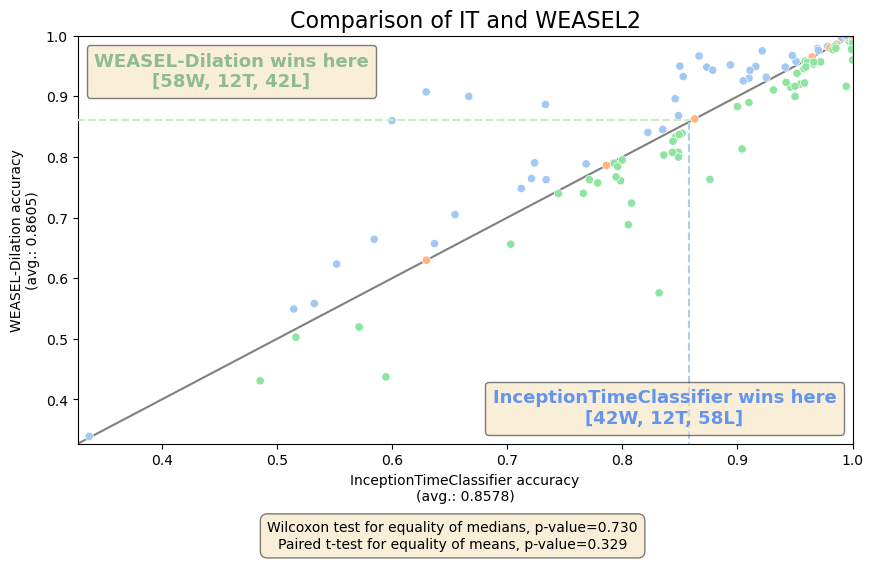

In [10]:
methods = ["InceptionTimeClassifier", "WEASEL-Dilation"]

results = get_estimator_results_as_array(estimators=methods)

plot = plot_scatter(
    results[0],
    methods[0],
    methods[1],
    title="Comparison of IT and WEASEL2",
)
plot.show()

[timeseriesclassification.com](https://timeseriesclassification.com) has results for classification, clustering and regression. We are constantly
updating the results as we generate them. To find out which estimators have results
 `get_available_estimators`

In [11]:
from aeon.benchmarking import get_available_estimators

print(get_available_estimators(task="Classification"))

print(get_available_estimators(task="Regression"))

print(get_available_estimators(task="Clustering"))

  classification
0    FreshPRINCE
1            HC2
2       Hydra-MR
3     InceptionT
4             PF
5           RDST
6          RSTSF
7       WEASEL_D
    regression
0  FreshPRINCE
  clustering
0     KMeans


# References
[1] Middlehurst et al. "Bake off redux: a review and experimental evaluation of
recent time series classification algorithms", 2023, [arXiv](https://arxiv.org/abs/2304.13029)

[2] Holder et al.  "A Review and Evaluation of Elastic Distance Functions for Time Series Clustering", 2023, [arXiv](https://arxiv.org/abs/2205.15181) [KAIS](https://link.springer.com/article/10.1007/s10115-023-01952-0)

[3] Guijo-Rubio et al. "Unsupervised Feature Based Algorithms for Time Series
Extrinsic Regression", 2023 [arXiv](https://arxiv.org/abs/2305.01429)

[4] Middlehurst and Bagnall, "The FreshPRINCE: A Simple Transformation Based Pipeline
 Time Series Classifier", 2022 [arXiv](https://arxiv.org/abs/2201.12048)

[5] Fawaz et al. "InceptionTime: Finding AlexNet for time series classification", 2020
[DAMI](https://link.springer.com/article/10.1007/s10618-020-00710-y)

[6] Middlehurst et al. "HIVE-COTE 2.0: a new meta ensemble for time series
classification", [MACH](https://link.springer.com/article/10.1007/s10994-021-06057-9)

[7] Schäfer and Leser, "WEASEL 2.0 - A Random Dilated Dictionary Transform for Fast, Accurate and Memory Constrained Time Series Classification", 2023 [arXiv](https://arxiv.org/abs/2301.10194)

[8] García and Herrera, "An extension on 'statistical comparisons of classifiers over multiple data sets' for all pairwise comparisons", 2008 [JMLR](https://www.jmlr.org/papers/volume9/garcia08a/garcia08a.pdf)

[9] Benavoli et al. "Should We Really Use Post-Hoc Tests Based on Mean-Ranks?", 2016 [JMLR](https://jmlr.org/papers/v17/benavoli16a.html)

[10] Demsar, "Statistical Comparisons of Classifiers
over Multiple Data Sets" [JMLR](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf)
